In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from omegaconf import OmegaConf
from models.flow_module import FlowModule
import torch
from data.pdb_dataloader import PdbDataModule
import glob
import GPUtil
from data import utils as du
import numpy as np
import tree
from data import so3_utils
from data import all_atom
from analysis import utils as au
from openfold.utils.superimposition import superimpose
import matplotlib.pyplot as plt

def atom37_from_trans_rot(trans, rots, res_mask):
        rigids = du.create_rigid(rots, trans)
        atom37 = all_atom.compute_backbone(
            rigids,
            torch.zeros(
                trans.shape[0],
                trans.shape[1],
                2,
                device=trans.device
            )
        )[0]
        atom37 = atom37.detach().cpu()
        batch_atom37 = []
        num_batch = res_mask.shape[0]
        for i in range(num_batch):
            batch_atom37.append(
                du.adjust_oxygen_pos(atom37[i], res_mask[i])
            )
        return torch.stack(batch_atom37)

def process_trans_rot_traj(trans_traj, rots_traj, res_mask):
    res_mask = res_mask.detach().cpu()
    atom37_traj = [
         atom37_from_trans_rot(trans, rots, res_mask)
         for trans, rots in zip(trans_traj, rots_traj) 
    ]
    atom37_traj = torch.stack(atom37_traj).swapaxes(0, 1)
    return atom37_traj 

In [3]:
save_dir = 'notebook_debug/'
num_timesteps = 100
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Setup lightning module

ckpt_dir = 'ckpt/se3-fm/baseline_fixed/2023-09-13_08-12-53'
# ckpt_dir = 'ckpt/se3-fm/warm_start_dist_loss/2023-09-15_00-51-09'

ckpt_path = sorted(glob.glob(os.path.join(ckpt_dir, '*.ckpt')))[-1]
print(ckpt_path)

cfg_path = os.path.join(ckpt_dir, 'config.yaml')
ckpt_cfg = OmegaConf.load(cfg_path)
base_path = 'configs/base.yaml'
base_cfg = OmegaConf.load(base_path)

OmegaConf.set_struct(base_cfg, False)
OmegaConf.set_struct(ckpt_cfg, False)
cfg = OmegaConf.merge(base_cfg, ckpt_cfg)
cfg.experiment.checkpointer.dirpath = './'

flow = FlowModule.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    model_cfg=cfg.model,
    experiment_cfg=cfg.experiment
) 
_ = flow.eval()

ckpt/se3-fm/baseline_fixed/2023-09-13_08-12-53/last.ckpt


In [5]:
# Set up data module
data_module = PdbDataModule(cfg.data)
data_module.setup('fit')
train_dataloader = data_module.train_dataloader(
    num_replicas=1,
    rank=1
)
data_iter = iter(train_dataloader)


In [6]:
# Search for a reasonable batch
stop_search = False
while not stop_search: 
    batch = next(data_iter)
    num_batch, num_res, _ = batch['trans_1'].shape
    if num_res > 100:
        stop_search = True
print(f'Found batch with {num_res} residues, {num_batch} batch size')

# Set up device and cuda
num_batch, num_res, _ = batch['trans_1'].shape
cuda_id = GPUtil.getAvailable(order='memory', limit = 8)[0]
device = f'cuda:{cuda_id}'
# device = 'cpu'
print(f'Using device {device}')
flow.model = flow.model.to(device)
batch = tree.map_structure(lambda x: x.to(device), batch)

Found batch with 113 residues, 62 batch size
Using device cuda:3


In [43]:
# True protein
gt_trans_1 = batch['trans_1']
gt_rotmats_1 = batch['rotmats_1']
res_mask = batch['res_mask']

gt_atom37 = atom37_from_trans_rot(
    gt_trans_1.detach().cpu(),
    gt_rotmats_1.detach().cpu(),
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)
gt_rotvec = so3_utils.rotmat_to_rotvec(gt_rotmats_1)

In [45]:
# Take lots of samples
num_samples = 100
all_noisy_batches = [flow._corrupt_batch(batch) for _ in range(num_samples)]

all_t = du.to_numpy(torch.stack([x['t'] for x in all_noisy_batches]).reshape(-1))

all_rotmats_t = torch.stack([x['rotmats_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3, 3)
all_trans_t = torch.stack([x['trans_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3)
all_rotvecs_t = so3_utils.rotmat_to_rotvec(all_rotmats_t)
all_gt_rotvec = gt_rotvec[None].repeat(num_samples, 1, 1, 1).reshape(-1, num_res, 3)
all_gt_trans = gt_trans_1[None].repeat(num_samples, 1, 1, 1).reshape(-1, num_res, 3)

In [73]:
rot_dist_t = du.to_numpy(torch.mean(torch.linalg.norm(all_rotvecs_t - all_gt_rotvec, dim=-1), dim=-1))
trans_dist_t = du.to_numpy(torch.mean(torch.linalg.norm(all_trans_t - all_gt_trans, dim=-1), dim=-1))

Text(0.5, 1.0, 'RMSD of $x_t$ and $x_1$')

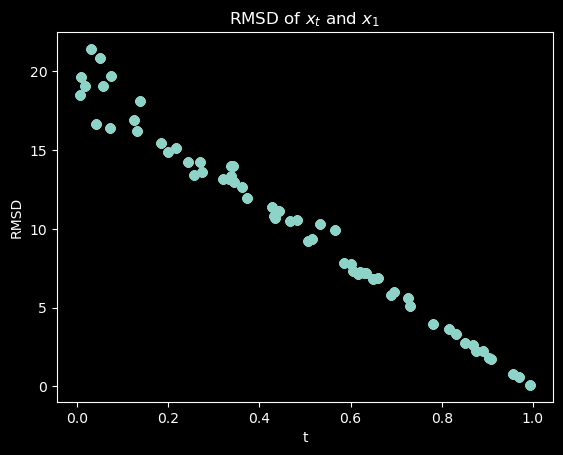

In [71]:
plt.scatter(all_t, trans_dist_t)
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title(r'RMSD of $x_t$ and $x_1$')

Text(0.5, 1.0, 'RMSD of $r_t$ and $r_1$')

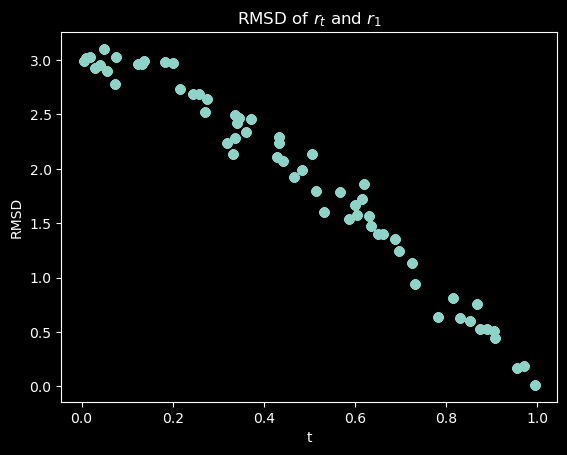

In [74]:
plt.scatter(all_t, rot_dist_t)
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title(r'RMSD of $r_t$ and $r_1$')

In [75]:
all_gt_rot_vf = []
for noisy_batch in all_noisy_batches:
    gt_rot_vf = so3_utils.calc_rot_vf(
        noisy_batch['rotmats_t'].type(torch.float32),
        gt_rotmats_1.type(torch.float32)
    )
    all_gt_rot_vf.append(gt_rot_vf)

In [76]:
all_rot_vf_mag = du.to_numpy(torch.concat([torch.linalg.norm(x, dim=-1) for x in all_gt_rot_vf]).reshape(-1, num_res))

Text(0.5, 1.0, 'Magnitude of rotation vector field')

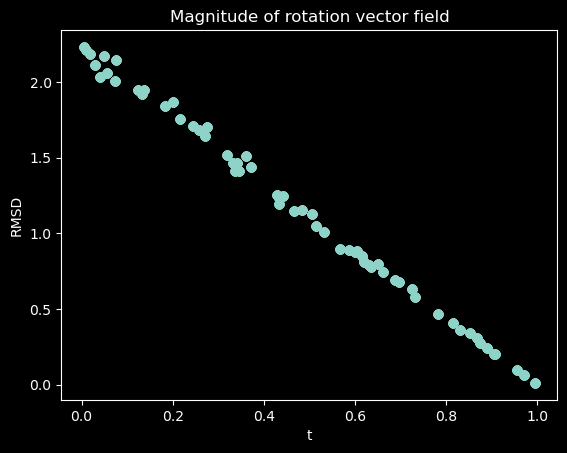

In [77]:
plt.scatter(all_t, np.mean(all_rot_vf_mag, axis=-1))
plt.xlabel('t')
plt.ylabel('RMSD')
plt.title('Magnitude of rotation vector field')

In [67]:
all_rot_vf_mag.max()

3.128121

# Model prediction at different timesteps

In [7]:
gt_ca_pos = batch['trans_1']
device = gt_ca_pos.device
num_batch = gt_ca_pos.shape[0]
ts = np.linspace(1e-3, 1.0, num_timesteps)
all_pred_ca = []
all_pred_transrot = []
all_gt_atom37 = []
for i,t in enumerate(ts):
    if i % 100 == 0:
        print(f'On t={t:.2f}')
    batch_t = torch.ones(num_batch, 1, 1, device=device) * t
    noisy_batch = flow._corrupt_batch(batch, t=batch_t)
    noisy_batch['t']
    with torch.no_grad():
        model_out = flow.forward(noisy_batch)
    all_pred_transrot.append((model_out['pred_trans'], model_out['pred_rotmats']))
    all_pred_ca.append(du.to_numpy(model_out['pred_trans']))

    gt_trans_t = noisy_batch['trans_t']
    gt_rotmats_t = noisy_batch['rotmats_t']

    noisy_gt_atom37 = atom37_from_trans_rot(
        gt_trans_t.detach().cpu(),
        gt_rotmats_t.detach().cpu(),
        noisy_batch['res_mask'].detach().cpu()
    )
    noisy_gt_atom37 = du.to_numpy(noisy_gt_atom37)
    all_gt_atom37.append(noisy_gt_atom37)



On t=0.00


/data/rsg/chemistry/jyim/mambaforge/envs/fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


In [8]:
# Save samples

all_pred_ca = np.stack(all_pred_ca)
all_pred_atom37 = np.stack(all_atom.transrot_to_atom37(
    all_pred_transrot,
    noisy_batch['res_mask']
))

os.makedirs(save_dir, exist_ok=True)
num_timesteps, num_batch, num_res, _, _ = all_pred_atom37.shape

for i in list(np.linspace(0, num_timesteps-1, 10).astype(int)):
    t = ts[i]
    atom37_t = all_pred_atom37[i]
    _ = au.write_prot_to_pdb(
        atom37_t,
        os.path.join(
            save_dir,
            f'model_out_len_{num_res}_t_{t:.2f}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_len_{num_res}_t_{t:.2f}.pdb'),
        no_indexing=True)
    
    print(f'Done with sample {i}, t={t:.2f}')

Done with sample 0, t=0.00
Done with sample 11, t=0.11
Done with sample 22, t=0.22
Done with sample 33, t=0.33
Done with sample 44, t=0.45
Done with sample 55, t=0.56
Done with sample 66, t=0.67
Done with sample 77, t=0.78
Done with sample 88, t=0.89
Done with sample 99, t=1.00


/tmp/ipykernel_3336717/947472559.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(gt_ca_pos)[None].repeat(num_timesteps, 1, 1, 1),


Text(0, 0.5, 'RMSD to ground truth')

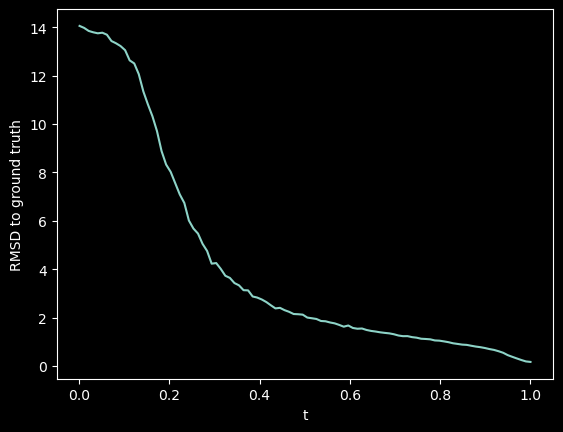

In [9]:
res_mask = batch['res_mask']
aligned_sample_ca, aligned_rmsd = superimpose(
    torch.tensor(gt_ca_pos)[None].repeat(num_timesteps, 1, 1, 1),
    torch.tensor(all_pred_ca).to(gt_ca_pos.device),
    res_mask[None].repeat(num_timesteps, 1, 1)
)
# torch.mean(aligned_rmsd)
ts_rmsd = du.to_numpy(torch.mean(aligned_rmsd, dim=-1))

plt.plot(ts, ts_rmsd)
plt.xlabel('t')
plt.ylabel('RMSD to ground truth')
# plt.plot(ts, noisy_rmsds)

Text(0.5, 0.98, "RMSD between model's x_0 output and ground truth")

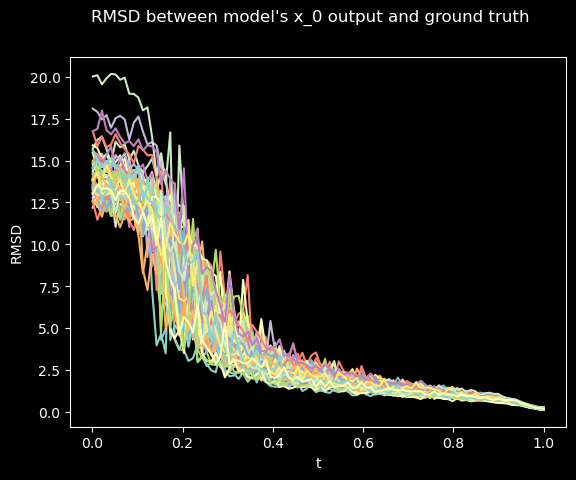

In [10]:
np_rmsd = du.to_numpy(aligned_rmsd)
for i in range(np_rmsd.shape[1]):
    plt.plot(ts, np_rmsd[:, i])
plt.xlabel('t')
plt.ylabel('RMSD')
plt.suptitle('RMSD between model\'s x_0 output and ground truth')

# Full sampling

In [13]:
min_t = 1e-3
t = torch.ones(num_batch, 1, 1, device=device) * min_t
res_mask = batch['res_mask']
noisy_batch = flow._corrupt_batch(batch, t=t)
noisy_batch['t'] = t
do_sde = False
debug_trans = False
debug_rots = True

gt_trans_1 = batch['trans_1']
gt_rotmats_1 = batch['rotmats_1']

gt_atom37 = atom37_from_trans_rot(
    gt_trans_1.detach().cpu(),
    gt_rotmats_1.detach().cpu(),
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)

In [14]:
atom37_traj, model_traj = flow.run_sampling(
    (noisy_batch, None),
    return_traj=True,
    return_model_outputs=True,
    num_timesteps=num_timesteps,
    do_sde=do_sde,
    debug_trans=debug_trans,
    debug_rots=debug_rots,
)
atom37_traj = np.stack(atom37_traj).swapaxes(0, 1)
model_traj = np.stack(model_traj).swapaxes(0, 1)

/data/rsg/chemistry/jyim/mambaforge/envs/fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(


In [15]:
# Save samples
os.makedirs(save_dir, exist_ok=True)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
de_form = 'sde' if do_sde else 'ode'
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    traj_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'traj_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        model_traj[-1, i],
        os.path.join(
            save_dir,
            f'final_model_out_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        model_traj[:, i],
        os.path.join(
            save_dir,
            f'pred_traj_{i}_len_{num_res}_ts_{num_timesteps}_{de_form}.pdb'),
        no_indexing=True
    )  
    _ = au.write_prot_to_pdb(
        gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_{i}_len_{num_res}_ts_{num_timesteps}.pdb',
        ),
        no_indexing=True
    )
    print(f'Done with sample {i}')
final_samples = atom37_traj[:, -1]
_ = au.write_prot_to_pdb(
    final_samples,
    os.path.join(
        save_dir,
        'all_samples.pdb'),
    no_indexing=True
)


Done with sample 0
Done with sample 1
Done with sample 2
Done with sample 3
Done with sample 4


## Manual sampling

In [12]:
# Run sampling
trans_traj = [noisy_batch['trans_t']]
rots_traj = [noisy_batch['rotmats_t']]
ts = np.linspace(min_t, 1.0, num_timesteps)
t_1 = ts[0]
all_pred_transrot = []
trans_vf_traj = []
for i,t_2 in enumerate(ts[1:]):
    if (i+1) % 100 == 0:
        print(f"Step {i+1} / {len(ts)}")
    d_t = t_2 - t_1
    trans_t_1 = trans_traj[-1]
    rots_t_1 = rots_traj[-1]
    with torch.no_grad():
        noisy_batch['trans_t'] = trans_t_1
        noisy_batch['rotmats_t'] = rots_t_1
        noisy_batch['t'] = torch.ones((num_batch, 1)).to(device) * t_1
        model_out = flow.forward(noisy_batch)

    pred_trans_1 = model_out['pred_trans']
    # pred_trans_1 = batch['trans_1']
    pred_rots_1 = model_out['pred_rotmats']
    # pred_rots_1 = batch['rotmats_1']
    pred_rots_vf = model_out['pred_rots_vf']
    all_pred_transrot.append((pred_trans_1, pred_rots_1))

    trans_vf = (pred_trans_1 - trans_t_1) / (1 - t_1)
    trans_t_2 = trans_t_1 + trans_vf * d_t
    rots_t_2 = so3_utils.geodesic_t(
        d_t / (1 - t_1), pred_rots_1, rots_t_1, rot_vf=pred_rots_vf)
    t_1 = t_2
    trans_traj.append(trans_t_2)
    rots_traj.append(rots_t_2)

res_mask = noisy_batch['res_mask']
all_pred_atom37 = np.stack(all_atom.transrot_to_atom37(
    all_pred_transrot,
    res_mask
))
atom37_traj = process_trans_rot_traj(trans_traj, rots_traj, res_mask)
final_ca_pos = atom37_traj[:, -1, :, 1]
gt_ca_pos = noisy_batch['trans_1']
atom37_traj = du.to_numpy(atom37_traj)

gt_trans_1 = batch['trans_1']
gt_rotmats_1 = batch['rotmats_1']

gt_atom37 = atom37_from_trans_rot(
    gt_trans_1.detach().cpu(),
    gt_rotmats_1.detach().cpu(),
    res_mask.detach().cpu()
)
gt_atom37 = du.to_numpy(gt_atom37)


In [13]:
# Save samples
os.makedirs(save_dir, exist_ok=True)
num_batch, num_timesteps, num_res, _, _ = atom37_traj.shape
max_save = 5
for i, sample_traj in enumerate(atom37_traj):
    if i >= max_save:
        break
    traj_path = au.write_prot_to_pdb(
        sample_traj,
        os.path.join(
            save_dir,
            f'traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    sample_path = au.write_prot_to_pdb(
        sample_traj[-1],
        os.path.join(
            save_dir,
            f'sample_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_pred_atom37[-1, i],
        os.path.join(
            save_dir,
            f'final_model_out_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )
    _ = au.write_prot_to_pdb(
        all_pred_atom37[:, i],
        os.path.join(
            save_dir,
            f'pred_traj_{i}_len_{num_res}_ts_{num_timesteps}.pdb'),
        no_indexing=True
    )  
    _ = au.write_prot_to_pdb(
        gt_atom37[i],
        os.path.join(
            save_dir,
            f'gt_{i}_len_{num_res}_ts_{num_timesteps}.pdb',
        ),
        no_indexing=True
    )
    print(f'Done with sample {i}')
final_samples = atom37_traj[:, -1]
_ = au.write_prot_to_pdb(
    final_samples,
    os.path.join(
        save_dir,
        'all_samples.pdb'),
    no_indexing=True
)


Done with sample 0
Done with sample 1
Done with sample 2
Done with sample 3
Done with sample 4
